In [14]:
#|default_exp resnet

In [177]:
#|export

import torch
from torch import nn
from typing import Optional, List

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [ ]:
class NaiveLayer(nn.Module):
    def __init__(self, F, in_chan, out_chan, stride, padding, block:"NaiveBlock"=None, set_residuals=False):
        super().__init__()

        self.conv = nn.Conv2d(in_chan, out_chan, F, stride, padding)
        self.batch_norm = nn.BatchNorm2d(out_chan, 1e-4, 0.1)
        self.relu = nn.ReLU()
        self.block = block
        self.set_residuals = set_residuals

    def forward(self, X):
        X = self.conv(X)
        X = self.batch_norm(X)

        if self.block is not None and self.block.residual is not None:
            X += self.block.residual

        if self.set_residuals == True:
            self.block.residual = X
        
        X = self.relu(X)

        return X
    

class NaiveBlock(nn.Module):
    residual: Optional[torch.Tensor]
    def __init__(self,  init_chan, in_chan, Fs=[], stride=1, paddings=[], expansion=4, num_repeats=1):
        super().__init__()

        self.init_chan = init_chan
        
        sequence = []

        self.register_buffer("residual", None)
        # TODO: ensure that the residual from the previous block is passed onto this block

        for i in range(num_repeats):
            for idx, F in enumerate(Fs):
                if expansion is not None and idx == len(Fs) - 1:
                    sequence.append(NaiveLayer(F, in_chan, in_chan*expansion, stride, paddings[idx], block=self))
                    self.init_chan = in_chan*expansion
                elif idx == 0 and i == 0:
                    sequence.append(NaiveLayer(F, self.init_chan, in_chan, stride, paddings[idx], self, set_residuals=True))
                elif idx == 0:
                    sequence.append(NaiveLayer(F, self.init_chan, in_chan, stride, paddings[idx]))
                else:
                    sequence.append(NaiveLayer(F, in_chan, in_chan, stride, paddings[idx]))

        self.sequence = nn.Sequential(*sequence)

    def forward(self, X):
        return self.sequence(X)


class NaiveResNet50(nn.Module):

    def __init__(self):
        super().__init__()

        self.register_buffer("global_residual", None)

        self.conv1 = NaiveLayer(7, in_chan=3, out_chan=64, stride=2, padding=3)
        self.conv2_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = NaiveBlock(init_chan=64, in_chan=64, Fs=[1,3,1], stride=1, paddings=[0,1,0], expansion=4, num_repeats=3)
        self.conv3 = NaiveBlock(init_chan=256, in_chan=128, Fs=[1,3,1], stride=1, paddings=[0,1,0], expansion=4, num_repeats=4)
        self.conv4 = NaiveBlock(init_chan=512, in_chan=256, Fs=[1,3,1], stride=1, paddings=[0,1,0], expansion=4, num_repeats=6)
        self.conv5 = NaiveBlock(init_chan=1024, in_chan=512, Fs=[1,3,1], stride=1, paddings=[0,1,0], expansion=4, num_repeats=3)
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(512*4, 1000) 

    
    def forward(self, X):
        X = self.conv1(X)
        X = self.conv2_pool(X)
        X = self.conv2(X)
        X = self.conv3(X)
        X = self.conv4(X)
        X = self.conv5(X)
        X = self.avg_pool(X)
        X = self.flatten(X)
        X = self.fc(X)
        return X


In [ ]:

class block(nn.Module):
    def __init__(self, out_channels, repeats):
        super().__init__()

        self.sequence = nn.Sequential(
            *[nn.Conv2d(56 * 56 * out_channels, 56 * 56 * out_channels, kernel_size=1),
            nn.Conv2d(56 * 56 * out_channels, 56 * 56 * out_channels, kernel_size=3, padding=1),
            nn.Conv2d(56 * 56 * out_channels, 56 * 56 * out_channels*4, kernel_size=1) for i in range(repeats)],
        )

    def forward(self, X):
        return self.sequence(X)

class ResNet50(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
                224 * 224 * 3, 112 * 112 * 64, kernel_size=7, stride=2, padding=3
            )
        self.bridge_pool = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv2 = block(64, 3)
        self.conv3 = block(128, 4)
        self.conv4 = block(256, 6)
        self.conv5 = block(512, 3)
        self.avg_pool = nn.AvgPool2d()

    def forward(self, X):
        return (chain(X)
                (self.conv1)
                (self.bridge_pool)
                (self.conv1)
                (self.conv2)
                (self.conv3)
                (self.conv4)
                (self.conv5)
                (self.avg_pool)())

In [ ]:
class Layer:
    def __init__(
        self,
        repeats: int,
        # inner loop
        out_chans: List[int],
        kernel_sizes: List[int],
        strides: List[int],
        paddings: List[int],
    ):
        self.repeats = repeats

        # inner loop
        self.out_chans = out_chans
        self.kernel_sizes = kernel_sizes
        self.strides = strides
        self.paddings = paddings

class ResNet(nn.Module):
    def __init__(self, layers: List[Layer], output_cats: int = 1000):
        super().__init__()
        self.output_cats = output_cats

        self.relu = nn.ReLU()

        # Initial
        self.conv_i = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn_conv_i = nn.BatchNorm2d(64)
        self.max_pool_i = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        resnet_layers = []

        curr_chan = 64

        # Resnet
        for layer_idx, layer in enumerate(layers):
            for i in range(layer.repeats):
                strides = (
                    [1] * len(layer.strides) if layer_idx == 0 or i != 0 else layer.strides
                )  # TODO: remove hardcoding like this

                identity_chans = None

                resnet_block = []
                # inner loop
                for j, _ in enumerate(layer.out_chans):
                    if j == 0:
                        in_chan = curr_chan  # input is the output of previous layer （from prev block)
                        identity_chans = curr_chan
                    else:
                        in_chan = layer.out_chans[
                            j - 1
                        ]  # input is the output of previous layer

                    conv_name = f"{layer_idx}_{i}_{j}_conv"
                    bn_name = f"{layer_idx}_{i}_{j}_bn"

                    setattr(
                        self,
                        conv_name,
                        nn.Conv2d(
                            in_chan,  # [64,64,64], [256,64,64] | [256,128,128], [512,128,128]
                            layer.out_chans[j],  # [64,64,256] | [128,128,512]
                            layer.kernel_sizes[j],  # [1,3,1]
                            strides[j],  # [1,1,1] | [1,2,1]
                            layer.paddings[j],  # [0,1,0]
                            bias=False,  # no need bias as batch norm subtracts it (via the mean)
                        ),
                    )
                    resnet_block.append(conv_name)
                    setattr(self, bn_name, nn.BatchNorm2d(layer.out_chans[j]))
                    resnet_block.append(bn_name)

                    if j < len(layer.out_chans) - 1:
                        resnet_block.append("relu")

                    curr_chan = layer.out_chans[j]

                #   output         residuals
                if curr_chan != identity_chans or max(strides) > 1:
                    identity_downsample = [
                        nn.Conv2d(
                            in_channels=identity_chans,
                            out_channels=curr_chan,
                            kernel_size=1,
                            stride=max(strides),
                            bias=False,  # if stride 2, then output is halved, so need to halve identity too
                        ),
                        nn.BatchNorm2d(curr_chan),
                    ]

                    ds_name = f"{layer_idx}_{i}_ds"
                    setattr(self, ds_name, nn.Sequential(*identity_downsample))
                    resnet_block.append(ds_name)
                else:
                    resnet_block.append(f"{layer_idx}_{i}_identity")

                resnet_block.append("relu")
                resnet_layers.append(resnet_block)

        self.resnet_layers = resnet_layers

        # Ending
        self.avg_pool_e = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(layers[-1].out_chans[-1], output_cats)

    def forward(self, X: torch.Tensor):
        X = self.conv_i(X)
        X = self.bn_conv_i(X)
        X = self.relu(X)
        X = self.max_pool_i(X)

        identity = None
        for b_i, block in enumerate(self.resnet_layers):
            for i, net_name in enumerate(block):
                net = getattr(self, net_name, None)

                if i == 0:
                    identity = X

                if "ds" in net_name:
                    downsampled_identity = net(identity)
                    X += downsampled_identity
                    continue

                if "identity" in net_name and net is None:
                    X += identity
                    continue

                X = net(X)

        X = self.avg_pool_e(X)
        # [N, 2048, 1, 1]

        X = X.flatten(1, 3)
        # [N, 2048]

        X = self.fc(X)
        # [N, 1000]

        return X


resnet_18 = ResNet(
    [
        Layer(2, [64, 64], [3, 3], [2, 1], [1,1]),
        Layer(2, [128, 128], [3, 3], [2, 1], [1,1]),
        Layer(2, [256, 256], [3, 3], [2, 1], [1,1]),
        Layer(2, [512, 512], [3, 3], [2, 1], [1,1]),
    ]
)

resnet_34 = ResNet(
    [
        Layer(3, [64, 64], [3, 3], [2, 1], [1,1]),
        Layer(4, [128, 128], [3, 3], [2, 1], [1,1]),
        Layer(6, [256, 256], [3, 3], [2, 1], [1,1]),
        Layer(3, [512, 512], [3, 3], [2, 1], [1,1]),
    ]
)

resnet_50 = ResNet(
    [
        Layer(3, [64, 64, 256], [1, 3, 1], [1, 2, 1], [0, 1, 0]),
        Layer(4, [128, 128, 512], [1, 3, 1], [1, 2, 1], [0, 1, 0]),
        Layer(6, [256, 256, 1024], [1, 3, 1], [1, 2, 1], [0, 1, 0]),
        Layer(3, [512, 512, 2048], [1, 3, 1], [1, 2, 1], [0, 1, 0]),
    ]
)

resnet_101 = ResNet(
    [
        Layer(3, [64, 64, 256], [1, 3, 1], [1, 2, 1], [0, 1, 0]),
        Layer(4, [128, 128, 512], [1, 3, 1], [1, 2, 1], [0, 1, 0]),
        Layer(23, [256, 256, 1024], [1, 3, 1], [1, 2, 1], [0, 1, 0]),
        Layer(3, [512, 512, 2048], [1, 3, 1], [1, 2, 1], [0, 1, 0]),
    ]
)

resnet_152 = ResNet(
    [
        Layer(3, [64, 64, 256], [1, 3, 1], [1, 2, 1], [0, 1, 0]),
        Layer(8, [128, 128, 512], [1, 3, 1], [1, 2, 1], [0, 1, 0]),
        Layer(36, [256, 256, 1024], [1, 3, 1], [1, 2, 1], [0, 1, 0]),
        Layer(3, [512, 512, 2048], [1, 3, 1], [1, 2, 1], [0, 1, 0]),
    ]
)

In [221]:
# |export


class Layer:
    def __init__(
        self,
        repeats: int,
        # inner loop
        out_chans: List[int],
        kernel_sizes: List[int],
        strides: List[int],
        paddings: List[int],
    ):
        self.repeats = repeats

        # inner loop
        self.out_chans = out_chans
        self.kernel_sizes = kernel_sizes
        self.strides = strides
        self.paddings = paddings


class LayerNet(nn.Module):
    def __init__(self, layer: Layer, layer_idx: int, prev_layer_chans: int):
        super().__init__()

        curr_chan = prev_layer_chans
        self.relu = nn.ReLU()

        resnet_procedure = []

        for i in range(layer.repeats):
            strides = (
                [1] * len(layer.strides) if layer_idx == 0 or i != 0 else layer.strides
            )  # TODO: remove hardcoding like this

            identity_chans = None

            resnet_block = []
            # inner loop
            for j, _ in enumerate(layer.out_chans):
                if j == 0:
                    in_chan = curr_chan  # input is the output of previous layer （from prev block)
                    identity_chans = curr_chan
                else:
                    in_chan = layer.out_chans[
                        j - 1
                    ]  # input is the output of previous layer

                conv = [
                    nn.Conv2d(
                        in_chan,  # [64,64,64], [256,64,64] | [256,128,128], [512,128,128]
                        layer.out_chans[j],  # [64,64,256] | [128,128,512]
                        layer.kernel_sizes[j],  # [1,3,1]
                        strides[j],  # [1,1,1] | [1,2,1]
                        layer.paddings[j],  # [0,1,0]
                        bias=False,  # no need bias as batch norm subtracts it (via the mean)
                    ),
                    nn.BatchNorm2d(layer.out_chans[j]),
                    nn.ReLU(),
                ]
                conv_sequential = (
                    nn.Sequential(*conv)
                    if j < len(layer.out_chans) - 1
                    else nn.Sequential(*conv[:-1])
                )
                resnet_block.append(f"{i}_{j}_conv")
                setattr(self, f"{i}_{j}_conv", conv_sequential)

                curr_chan = layer.out_chans[j]

            #   output         residuals
            if curr_chan != identity_chans or max(strides) > 1:
                identity_downsample = [
                    nn.Conv2d(
                        in_channels=identity_chans,
                        out_channels=curr_chan,
                        kernel_size=1,
                        stride=max(strides),
                        bias=False,  # if stride 2, then output is halved, so need to halve identity too
                    ),
                    nn.BatchNorm2d(curr_chan),
                ]

                ds_name = f"{layer_idx}_{i}_ds"
                setattr(self, ds_name, nn.Sequential(*identity_downsample))
                resnet_block.append(ds_name)
            else:
                resnet_block.append(f"{layer_idx}_{i}_identity")

            resnet_block.append("relu")
            resnet_procedure.append(resnet_block)

        self.resnet_procedure = resnet_procedure

    def forward(self, X):
        for block in self.resnet_procedure:
            for i, net_name in enumerate(block):
                net = getattr(self, net_name, None)

                if i == 0:
                    identity = X

                if "ds" in net_name:
                    downsampled_identity = net(identity)
                    X += downsampled_identity
                    continue

                if "identity" in net_name and net is None:
                    X += identity
                    continue

                X = net(X)
        return X


class ResNet(nn.Module):
    def __init__(self, layers: List[Layer], output_cats: int = 1000):
        super().__init__()
        self.output_cats = output_cats
        self.layers = layers

        self.relu = nn.ReLU()

        # Initial
        self.conv_i = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn_conv_i = nn.BatchNorm2d(64)
        self.max_pool_i = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Resnet
        for layer_idx, layer in enumerate(layers):
            prev_layer_chans = (
                64 if layer_idx == 0 else layers[layer_idx - 1].out_chans[-1]
            )
            setattr(
                self, f"layer_{layer_idx}", LayerNet(layer, layer_idx, prev_layer_chans)
            )

        # Ending
        self.avg_pool_e = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(layers[-1].out_chans[-1], output_cats)

    def forward(self, X: torch.Tensor):
        X = self.conv_i(X)
        X = self.bn_conv_i(X)
        X = self.relu(X)
        X = self.max_pool_i(X)

        for layer_idx, _ in enumerate(self.layers):
            layer_net = getattr(self, f"layer_{layer_idx}")
            X = layer_net(X)

        X = self.avg_pool_e(X)
        # [N, 2048, 1, 1]

        X = X.flatten(1, 3)
        # [N, 2048]

        X = self.fc(X)
        # [N, 1000]

        return X


resnet_18 = ResNet(
    [
        Layer(2, [64, 64], [3, 3], [2, 1], [1, 1]),
        Layer(2, [128, 128], [3, 3], [2, 1], [1, 1]),
        Layer(2, [256, 256], [3, 3], [2, 1], [1, 1]),
        Layer(2, [512, 512], [3, 3], [2, 1], [1, 1]),
    ]
)

resnet_34 = ResNet(
    [
        Layer(3, [64, 64], [3, 3], [2, 1], [1, 1]),
        Layer(4, [128, 128], [3, 3], [2, 1], [1, 1]),
        Layer(6, [256, 256], [3, 3], [2, 1], [1, 1]),
        Layer(3, [512, 512], [3, 3], [2, 1], [1, 1]),
    ]
)

resnet_50 = ResNet(
    [
        Layer(3, [64, 64, 256], [1, 3, 1], [1, 2, 1], [0, 1, 0]),
        Layer(4, [128, 128, 512], [1, 3, 1], [1, 2, 1], [0, 1, 0]),
        Layer(6, [256, 256, 1024], [1, 3, 1], [1, 2, 1], [0, 1, 0]),
        Layer(3, [512, 512, 2048], [1, 3, 1], [1, 2, 1], [0, 1, 0]),
    ]
)

resnet_101 = ResNet(
    [
        Layer(3, [64, 64, 256], [1, 3, 1], [1, 2, 1], [0, 1, 0]),
        Layer(4, [128, 128, 512], [1, 3, 1], [1, 2, 1], [0, 1, 0]),
        Layer(23, [256, 256, 1024], [1, 3, 1], [1, 2, 1], [0, 1, 0]),
        Layer(3, [512, 512, 2048], [1, 3, 1], [1, 2, 1], [0, 1, 0]),
    ]
)

resnet_152 = ResNet(
    [
        Layer(3, [64, 64, 256], [1, 3, 1], [1, 2, 1], [0, 1, 0]),
        Layer(8, [128, 128, 512], [1, 3, 1], [1, 2, 1], [0, 1, 0]),
        Layer(36, [256, 256, 1024], [1, 3, 1], [1, 2, 1], [0, 1, 0]),
        Layer(3, [512, 512, 2048], [1, 3, 1], [1, 2, 1], [0, 1, 0]),
    ]
)

In [ ]:
# |export

train_transform = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)
test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

train_data = torchvision.datasets.CIFAR10(root="../data", train=True, download=True, transform=train_transform)
test_data = torchvision.datasets.CIFAR10(root="../data", train=False, download=True, transform=test_transform)


train_dataloader = DataLoader(train_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)


In [206]:
import numpy as np

np.log(0.95**90 * 0.05**10/ 0.50**90 * 0.50**10) 

np.float64(20.878055214376165)

In [ ]:
for X, y in train_dataloader:
    # print(X.shape)
    # idx = 6
    # plt.imshow(X[idx].permute(1,2,0))
    # print(y[idx], train_data.classes[y[idx]])
    
    # to_classnames = lambda x: train_data.classes[x]
    # with torch.no_grad():
    #     pred = model(X)
    #     pred_list = torch.argmax(pred, dim=1).detach().tolist()
    #     pred_list = list(map(to_classnames, pred_list))
    
    # y_cn = list(map(to_classnames, y))
    # for i, p in enumerate(pred_list):
    #     plt.imshow(X[i].permute(1,2,0))
    #     plt.show()
    #     print(f"Answer: {y_cn[i]}, pred: {p}")

    break

In [ ]:
def train(model, data, optimizer: torch.optim.AdamW, loss_func: nn.CrossEntropyLoss):
    for X, y in data:
        pred = model(X)

        loss = loss_func(pred, y)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

def test(model, data, loss_func: nn.CrossEntropyLoss):
    for X, y in data:

        with torch.no_grad():
            pred = model(X)
            loss = loss_func(pred,y)



model = ResNet(
    [
        Layer(3, [64, 64], [3, 3], [2, 1], [1,1]),
        Layer(4, [128, 128], [3, 3], [2, 1], [1,1]),
        Layer(6, [256, 256], [3, 3], [2, 1], [1,1]),
        Layer(3, [512, 512], [3, 3], [2, 1], [1,1]),
    ], output_cats=10
)


loss_func = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters())

epochs = 5

for i in range(epochs):
    train(model, train_dataloader, optimizer, loss_func)
    test(model, test_dataloader, loss_func)


IndentationError: expected an indented block after 'for' statement on line 2 (460439618.py, line 6)

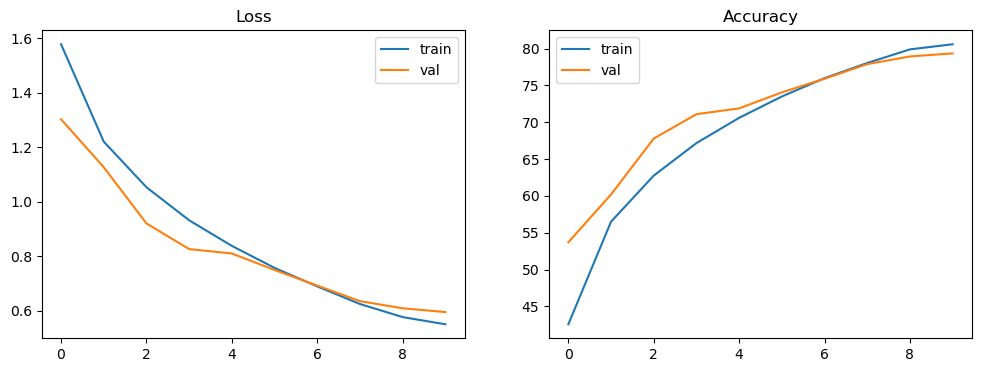

In [209]:
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter
from IPython.display import clear_output, display
import time
import os

# improved training loop with nice progress, TensorBoard logging, live matplotlib plots and checkpointing


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

# prepare model, loss, optimizer, scheduler
model = ResNet(
    [
        Layer(3, [64, 64], [3, 3], [2, 1], [1,1]),
        Layer(4, [128, 128], [3, 3], [2, 1], [1,1]),
        Layer(6, [256, 256], [3, 3], [2, 1], [1,1]),
        Layer(3, [512, 512], [3, 3], [2, 1], [1,1]),
    ], output_cats=10
).to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
scaler = torch.amp.GradScaler() if torch.cuda.is_available() else None

# TensorBoard writer
log_dir = "runs/resnet_experiment"
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir=log_dir)

# live plot setup
train_losses, val_losses = [], []
train_accs, val_accs = [], []

def _plot_progress():
    clear_output(wait=True)
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    axes[0].plot(train_losses, label="train")
    axes[0].plot(val_losses, label="val")
    axes[0].set_title("Loss"); axes[0].legend()
    axes[1].plot(train_accs, label="train")
    axes[1].plot(val_accs, label="val")
    axes[1].set_title("Accuracy"); axes[1].legend()
    display(fig)
    plt.close(fig)

def train_epoch(model, dataloader, optimizer, loss_func, epoch):
    model.train()
    pbar = tqdm(dataloader, desc=f"Train {epoch}", leave=False)
    running_loss = 0.0
    correct = 0
    total = 0
    for X, y in pbar:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        if scaler is not None:
            with torch.cuda.amp.autocast():
                pred = model(X)
                loss = loss_func(pred, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            pred = model(X)
            loss = loss_func(pred, y)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * X.size(0)
        _, preds = pred.max(1)
        correct += (preds == y).sum().item()
        total += X.size(0)

        pbar.set_postfix(loss=running_loss/total, acc=100*correct/total, lr=optimizer.param_groups[0]['lr'])

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def eval_epoch(model, dataloader, loss_func, epoch):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        pbar = tqdm(dataloader, desc=f"Eval {epoch}", leave=False)
        for X, y in pbar:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_func(pred, y)
            running_loss += loss.item() * X.size(0)
            _, preds = pred.max(1)
            correct += (preds == y).sum().item()
            total += X.size(0)
            pbar.set_postfix(loss=running_loss/total, acc=100*correct/total)

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

# training loop
epochs = 10
best_val_acc = 0.0
ckpt_dir = "checkpoints"
os.makedirs(ckpt_dir, exist_ok=True)

for epoch in range(1, epochs + 1):
    t0 = time.time()
    train_loss, train_acc = train_epoch(model, train_dataloader, optimizer, loss_func, epoch)
    val_loss, val_acc = eval_epoch(model, test_dataloader, loss_func, epoch)
    scheduler.step()

    train_losses.append(train_loss); val_losses.append(val_loss)
    train_accs.append(train_acc); val_accs.append(val_acc)

    # TensorBoard logging
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/val", val_loss, epoch)
    writer.add_scalar("Accuracy/train", train_acc, epoch)
    writer.add_scalar("Accuracy/val", val_acc, epoch)
    writer.add_scalar("LR", optimizer.param_groups[0]["lr"], epoch)

    # save best checkpoint
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({"model_state": model.state_dict(), "optimizer_state": optimizer.state_dict(), "epoch": epoch, "val_acc": val_acc},
                   os.path.join(ckpt_dir, "best.pth"))

    # print & live plot
    print(f"Epoch {epoch}/{epochs} - {time.time()-t0:.1f}s - train_loss {train_loss:.4f} train_acc {train_acc:.2f}% - val_loss {val_loss:.4f} val_acc {val_acc:.2f}% (best {best_val_acc:.2f}%)")
    _plot_progress()

writer.flush()
writer.close()


In [218]:
#|export

# testing shapes
img = torch.randn(1, 3, 224, 224)
res = resnet_50(img)
res.shape


torch.Size([1, 1000])

In [222]:
resnet_50

ResNet(
  (relu): ReLU()
  (conv_i): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn_conv_i): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool_i): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer_0): LayerNet(
    (relu): ReLU()
    (0_0_conv): Sequential(
      (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (0_1_conv): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (0_2_conv): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (0_0_d

# Answer

In [224]:
from dataclasses import dataclass
from typing import List, Type, Optional

import torch
import torch.nn as nn
from torch import Tensor


def conv3x3(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    """ResNet BasicBlock for 18/34. Stride applied to the FIRST 3x3."""
    expansion = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        norm_layer: Type[nn.Module] = nn.BatchNorm2d,
    ):
        super().__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes, 1)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample

        # Zero-init last BN so block starts as identity.
        nn.init.constant_(self.bn2.weight, 0.0)

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out


class Bottleneck(nn.Module):
    """ResNet Bottleneck for 50/101/152 (v1.5: stride on the 3x3)."""
    expansion = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        norm_layer: Type[nn.Module] = nn.BatchNorm2d,
    ):
        super().__init__()
        self.conv1 = conv1x1(inplanes, planes, 1)
        self.bn1 = norm_layer(planes)
        self.conv2 = conv3x3(planes, planes, stride)  # v1.5: stride here
        self.bn2 = norm_layer(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion, 1)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

        # Zero-init last BN so block starts as identity.
        nn.init.constant_(self.bn3.weight, 0.0)

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out


@dataclass(frozen=True)
class StageConfig:
    """One ResNet stage (a stack of identical blocks)."""
    block: Type[nn.Module]  # BasicBlock or Bottleneck
    planes: int             # inner channels for the block (64/128/256/512)
    num_blocks: int         # number of blocks in the stage
    stride: int             # stride for the FIRST block in the stage


class ResNet(nn.Module):
    """Configurable ResNet with explicit blocks and ModuleList stages."""
    def __init__(
        self,
        stages: List[StageConfig],
        num_classes: int = 1000,
        norm_layer: Type[nn.Module] = nn.BatchNorm2d,
        zero_init_residual: bool = True,  # kept True by default as suggested
    ):
        super().__init__()
        self.num_classes = num_classes
        self.norm_layer = norm_layer

        # Stem
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Stages
        self.stages = nn.ModuleList()
        for cfg in stages:
            stage = self._make_layer(cfg.block, cfg.planes, cfg.num_blocks, stride=cfg.stride, norm_layer=norm_layer)
            self.stages.append(stage)

        # Head
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(self.inplanes, num_classes)

        # Optionally zero-init last BN was already done inside blocks
        # Here we could also Kaiming-init convs if needed
        if zero_init_residual:
            pass

    def _make_layer(
        self,
        block: Type[nn.Module],
        planes: int,
        blocks: int,
        stride: int,
        norm_layer: Type[nn.Module],
    ) -> nn.Sequential:
        downsample = None
        out_channels = planes * block.expansion

        if stride != 1 or self.inplanes != out_channels:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, out_channels, stride),
                norm_layer(out_channels),
            )

        layers: List[nn.Module] = []
        layers.append(block(self.inplanes, planes, stride, downsample, norm_layer))
        self.inplanes = out_channels
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, 1, None, norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        for stage in self.stages:
            x = stage(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


# Factory helpers (canonical configs)
def resnet18(num_classes: int = 1000) -> ResNet:
    stages = [
        StageConfig(BasicBlock, 64, 2, 1),
        StageConfig(BasicBlock, 128, 2, 2),
        StageConfig(BasicBlock, 256, 2, 2),
        StageConfig(BasicBlock, 512, 2, 2),
    ]
    return ResNet(stages, num_classes=num_classes)


def resnet34(num_classes: int = 1000) -> ResNet:
    stages = [
        StageConfig(BasicBlock, 64, 3, 1),
        StageConfig(BasicBlock, 128, 4, 2),
        StageConfig(BasicBlock, 256, 6, 2),
        StageConfig(BasicBlock, 512, 3, 2),
    ]
    return ResNet(stages, num_classes=num_classes)


def resnet50(num_classes: int = 1000) -> ResNet:
    stages = [
        StageConfig(Bottleneck, 64, 3, 1),
        StageConfig(Bottleneck, 128, 4, 2),
        StageConfig(Bottleneck, 256, 6, 2),
        StageConfig(Bottleneck, 512, 3, 2),
    ]
    return ResNet(stages, num_classes=num_classes)


def resnet101(num_classes: int = 1000) -> ResNet:
    stages = [
        StageConfig(Bottleneck, 64, 3, 1),
        StageConfig(Bottleneck, 128, 4, 2),
        StageConfig(Bottleneck, 256, 23, 2),
        StageConfig(Bottleneck, 512, 3, 2),
    ]
    return ResNet(stages, num_classes=num_classes)


def resnet152(num_classes: int = 1000) -> ResNet:
    stages = [
        StageConfig(Bottleneck, 64, 3, 1),
        StageConfig(Bottleneck, 128, 8, 2),
        StageConfig(Bottleneck, 256, 36, 2),
        StageConfig(Bottleneck, 512, 3, 2),
    ]
    return ResNet(stages, num_classes=num_classes)


# Quick smoke test
def _count_params(m: nn.Module) -> int:
    return sum(p.numel() for p in m.parameters())


def _test():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    builders = [resnet18, resnet34, resnet50, resnet101, resnet152]

    for build in builders:
        model = build(num_classes=1000).to(device)
        x = torch.randn(2, 3, 224, 224, device=device)
        y = model(x)
        assert y.shape == (2, 1000), f"Bad output shape for {build.__name__}: {y.shape}"
        params_m = _count_params(model) / 1e6
        print(f"{build.__name__}: params ≈ {params_m:.2f}M, output {tuple(y.shape)}")


if __name__ == "__main__":
    _test()

resnet18: params ≈ 11.69M, output (2, 1000)
resnet34: params ≈ 21.80M, output (2, 1000)
resnet50: params ≈ 25.56M, output (2, 1000)
resnet101: params ≈ 44.55M, output (2, 1000)
resnet152: params ≈ 60.19M, output (2, 1000)


In [225]:
resnet50()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stages): ModuleList(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [223]:
from nbdev.export import nb_export 

nb_export('resnet.ipynb', '../src/')